In [1]:
import rdkit
from torch_geometric.datasets import MoleculeNet
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import clear_output

In [2]:
# Load the ESOL dataset
data = MoleculeNet(root=".", name="ESOL")
data

ESOL(1128)

In [3]:
n=10
print(data[n])
print("\n")

print("x",data[n]["x"].shape)
print("\n")

print("edge_index",data[n]["edge_index"])
print("\n")

print("edge_attr",data[n]["edge_attr"])

Data(x=[6, 9], edge_index=[2, 12], edge_attr=[12, 3], smiles='O=C1CCCN1', y=[1, 1])


x torch.Size([6, 9])


edge_index tensor([[0, 1, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5],
        [1, 0, 2, 5, 1, 3, 2, 4, 3, 5, 1, 4]])


edge_attr tensor([[2, 0, 1],
        [2, 0, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 1],
        [1, 0, 0]])


In [4]:
print(data[n]["edge_index"])

tensor([[0, 1, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5],
        [1, 0, 2, 5, 1, 3, 2, 4, 3, 5, 1, 4]])


In [5]:
print(data[n]["edge_attr"])

tensor([[2, 0, 1],
        [2, 0, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 1],
        [1, 0, 0]])


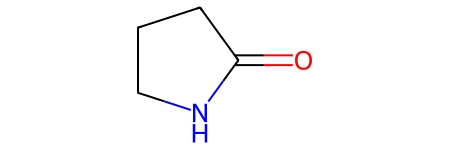

In [6]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
molecule = Chem.MolFromSmiles(data[n]["smiles"])
molecule

In [7]:
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  734
Dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Sample  nodes:  32
Sample  edges:  68


In [8]:
# Investiagte the features of the node of graph 
data[0].x

# Investigating the edges in sparse COO format
# Shape [2, num_edges]
data[0].edge_index.t()

# See the target value of data[0]
data[0].y

tensor([[-0.7700]])

In [9]:
data[0]["smiles"]

# Result SMILE string

'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '

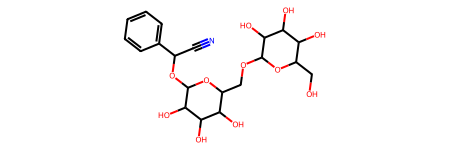

In [10]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
molecule = Chem.MolFromSmiles(data[0]["smiles"])
molecule

In [15]:
printdata[1]

tensor([[-3.3000]])

In [12]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)
        
        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
          
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


In [ ]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)  

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)     
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss, embedding

print("Starting training...")
losses = []
for epoch in range(2000):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 11.665946960449219
Epoch 100 | Train Loss 0.8510217666625977
Epoch 200 | Train Loss 1.1138055324554443
Epoch 300 | Train Loss 0.3321680724620819


In [ ]:
# torch.save(model.state_dict(),"model")
# model.load_state_dict(torch.load("model"))

In [ ]:
# Visualize learning (training loss)
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

In [21]:
import pandas as pd 

# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
# df["y_real"] = df["y_real"].apply(lambda row: row[0])
# df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
# df

<Axes: xlabel='y_real', ylabel='y_pred'>

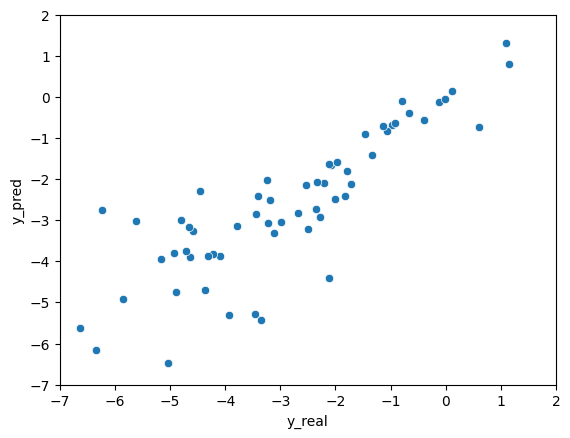

In [16]:
plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt

In [7]:
def particle_shift(particles,shift=10):

    ### Y shift ###
    y_pos = particles.copy()
    y_pos["y"] = particles["y"]+shift

    y_neg = particles.copy()
    y_neg["y"] = particles["y"]-shift

    ### Z shift ###
    z_pos = particles.copy()
    z_pos["z"] = particles["z"]+shift

    z_neg = particles.copy()
    z_neg["z"] = particles["z"]-shift

    ### Diagonal shifts ###
    ### y_pos_z_pos ###
    y_pos_z_pos = particles.copy()
    y_pos_z_pos["y"] = particles["y"]+shift
    y_pos_z_pos["z"] = particles["z"]+shift

    ### y_pos_z_neg ###
    y_pos_z_neg = particles.copy()
    y_pos_z_neg["y"] = particles["y"]+shift
    y_pos_z_neg["z"] = particles["z"]-shift

    ### y_neg_z_pos ###
    y_neg_z_pos = particles.copy()
    y_neg_z_pos["y"] = particles["y"]-shift
    y_neg_z_pos["z"] = particles["z"]+shift

    ### y_neg_z_neg ###
    y_neg_z_neg = particles.copy()
    y_neg_z_neg["y"] = particles["y"]-shift
    y_neg_z_neg["z"] = particles["z"]-shift

    return pd.concat([particles,y_pos,y_neg,z_pos,z_neg,y_pos_z_pos,y_pos_z_neg,y_neg_z_pos,y_neg_z_neg])

In [8]:
### array Differences function ###

def array_difference(array1,array2):
    ### First one must be the bigger array ###
    set1 = set(map(tuple, array1))
    set2 = set(map(tuple, array2))
    
    # Find the set difference
    set_difference = set1 - set2

    # Convert the set difference back to a NumPy array
    return np.array(list(set_difference))


In [9]:
def get_edge_connections(poi,deg_1_neighbors,deg_2_neighbors):

    ### Poi : np.array() with size (3,) ###
    ### deg_1_neighbors,deg_2_neighbors : numpy arrays with size (n,3) and (m,3) ###
    ### As of now works for 2 degrees of connections ##S

    ### poi ###
    temp_1 = np.concatenate((poi[None,:], [[0]]), axis=1)
    
    ### 1st deg neighbors ###
    temp_2 = np.concatenate((deg_1_neighbors,np.ones_like(np.arange(deg_1_neighbors.shape[0]))[:,None]),axis=1)
    
    ### 2nd deg neighbors ###
    _,idx = np.unique(deg_2_neighbors_np,axis=0,return_index=True)
    idx = np.sort(idx)
    temp_3 = np.concatenate((deg_2_neighbors_np[idx],np.ones_like(np.arange(deg_2_neighbors_np[idx].shape[0]))[:,None]*2),axis=1)

    ### Define unique array ###
    unique_array = np.concatenate((temp_1,temp_2,temp_3))
    unique_array = np.concatenate((np.arange(unique_array.shape[0])[:,None],unique_array),axis=1)

    ### generating the graph connections ###
    graph_connections = list()
    
    ### poi and 1st order neighbors ###
    graph_connections.append( np.concatenate( (np.zeros_like(deg_1_neighbors[:,0][:,None])
                                              ,(np.arange(deg_1_neighbors.shape[0])+1)[:,None]),axis=1 ) )
    graph_connections[0] = graph_connections[0].astype(int)
    
    ### 1 and 2 order neighbors ###
    for i in range(len(deg_2_neighbors)):
        idx = np.where( (deg_2_neighbors[i]==unique_array[:,1:-1][:,None]).all(-1) )[0]
        graph_connections.append(np.concatenate((np.ones_like(idx[:,None])*(i+1),idx[:,None]),axis=1))
    
    return unique_array,np.vstack(graph_connections)

In [15]:
center_10 = pd.DataFrame(np.loadtxt("center_phi_10.dat"))
center_10 = center_10.rename(columns={ center_10.columns[3]: "x" , center_10.columns[4]: "y" , center_10.columns[5]: "z"  })
center_10 = center_10[(center_10['x']>7.5) & (center_10['x']<17.5)]

center_20 = pd.DataFrame(np.loadtxt("center_phi_20.dat"))
center_20 = center_20.rename(columns={ center_20.columns[3]: "x" , center_20.columns[4]: "y" , center_20.columns[5]: "z"  })
center_20 = center_20[(center_20['x']>7.5) & (center_20['x']<17.5)]

center_30 = pd.DataFrame(np.loadtxt("center_phi_30.dat"))
center_30 = center_30.rename(columns={ center_30.columns[3]: "x" , center_30.columns[4]: "y" , center_30.columns[5]: "z"  })
center_30 = center_30[(center_30['x']>7.5) & (center_30['x']<17.5)]

In [16]:
from scipy.spatial import cKDTree
center_shifted = particle_shift(center_30,shift=10)
points_ref = np.array(center_shifted[["x","y","z"]])
tree = cKDTree(points_ref)

poi = np.array(points_ref[22])
print(poi)
_,idx = tree.query(poi, k=5) 

[14.715189  1.409963  8.740084]


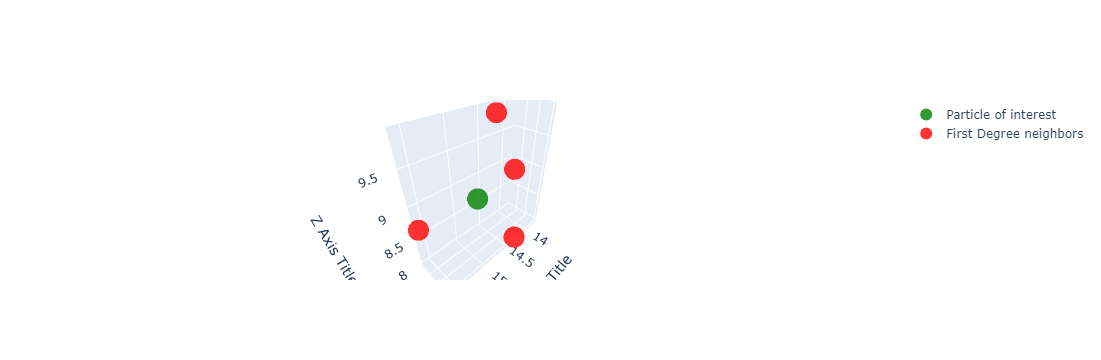

In [17]:
import numpy as np
import plotly.graph_objs as go
from IPython.display import display
from plotly.io import write_html

# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=[poi[0]],
    y=[poi[1]],
    z=[poi[2]],
    mode='markers',
    marker=dict(
        size=12,
        color="green",               
        opacity=0.8
    )
     ,name="Particle of interest"
)])

# Add trace for data2
fig.add_trace(go.Scatter3d(
    x=points_ref[idx][1:,0],
    y=points_ref[idx][1:,1],
    z=points_ref[idx][1:,2],
    mode='markers',
    marker=dict(
        size=12,
        color = "red",
        opacity=0.8
    ),
     name="First Degree neighbors"
))

# Update layout
fig.update_layout(scene=dict(
    xaxis_title='X Axis Title',
    yaxis_title='Y Axis Title',
    zaxis_title='Z Axis Title'
))

# Show plot
fig.show()
write_html(fig, file="scatter_plot.html")
# write_image(fig, file="scatter_plot.svg")
# display(fig)

In [18]:
### Generating Input Dataset ###
center_shifted = particle_shift(center_30,shift=10)
points_ref = np.array(center_shifted[["x","y","z"]])
tree = cKDTree(points_ref)
data = list()

for i in range(20):

    deg_1_neighbors = list()
    deg_2_neighbors = list()
    points_ref = np.array(center_shifted[["x","y","z"]])
    tree = cKDTree(points_ref)
    
    print("Particle Number : ",str(i+1))
    poi = np.array(points_ref[i])
    _,idx = tree.query(poi, k=5) 

    ### 1st degree neighbors ###
    deg_1_neighbors.append(points_ref[idx][1:])
    deg_1_neighbors = np.stack(deg_1_neighbors)[0]
    remaining_particles = array_difference(points_ref,points_ref[idx])
    tree = cKDTree(remaining_particles)
    
    ## 2nd degree neighbors ###
    for j in range(len(deg_1_neighbors)):
     
        _,idx = tree.query(deg_1_neighbors[j], k=5)
        deg_2_neighbors.append(remaining_particles[idx])
        # remaining_particles = array_difference(remaining_particles,remaining_particles[idx])
        # tree = cKDTree(remaining_particles)
    
    deg_2_neighbors_np = np.stack(deg_2_neighbors).reshape(np.stack(deg_2_neighbors).shape[0]*np.stack(deg_2_neighbors).shape[1],3)
    data.append(get_edge_connections(poi,deg_1_neighbors,deg_2_neighbors_np))
    clear_output(wait=True)

Particle Number :  20


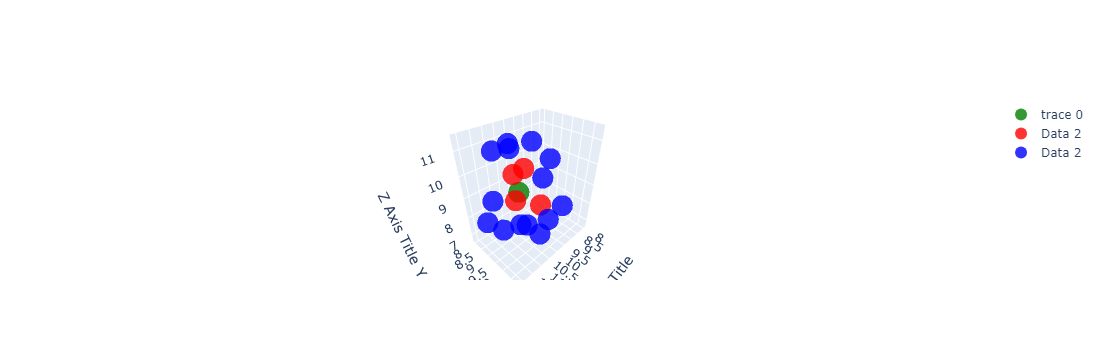

In [19]:
import numpy as np
import plotly.graph_objs as go
from IPython.display import display
from plotly.io import write_html

n=15
particle = data[n][0]
poi = particle[np.where(particle[:,-1]==0)[0][0]][1:-1]
deg_1 = particle[np.where(particle[:,-1]==1)[0]][:,1:-1]
deg_2 = particle[np.where(particle[:,-1]==2)[0]][:,1:-1]

### Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=[poi[0]],
    y=[poi[1]],
    z=[poi[2]],
    mode='markers',
    marker=dict(
        size=12,
        color="green",                # set color to the z coordinate
        opacity=0.8
    )
)])

# # Add trace for data2
fig.add_trace(go.Scatter3d(
    x=deg_1[:,0],
    y=deg_1[:,1],
    z=deg_1[:,2],
    mode='markers',
    marker=dict(
        size=12,             
        color='red',  
        opacity=0.8
    ),
    name='Data 2'
))

fig.add_trace(go.Scatter3d(
    x=deg_2[:,0],
    y=deg_2[:,1],
    z=deg_2[:,2],
    mode='markers',
    marker=dict(
        size=12,    
        color='blue',
        opacity=0.8
    ),
    name='Data 2'
))

# Update layout
fig.update_layout(scene=dict(
    xaxis_title='X Axis Title',
    yaxis_title='Y Axis Title',
    zaxis_title='Z Axis Title'
))

# Show plot
fig.show()
write_html(fig, file="scatter_plot.html")
# write_image(fig, file="scatter_plot.svg")
# # display(fig)

In [114]:
center_shifted = particle_shift(center_30,shift=10)
points_ref = np.array(center_shifted[["x","y","z"]])
tree = cKDTree(points_ref)
data = list()

for i in range(20):

    deg_1_neighbors = list()
    deg_2_neighbors = list()
    
    print("Particle Number : ",str(i))
    poi = np.array(points_ref[i+2])
    _,idx = tree.query(poi, k=5) 

    ### 1st degree neighbors ###
    deg_1_neighbors.append(points_ref[idx][1:])
    deg_1_neighbors = np.stack(deg_1_neighbors)[0]
    remaining_particles = array_difference(points_ref,points_ref[idx])
    tree = cKDTree(remaining_particles)
    
    ## 2nd degree neighbors ###
    for j in range(len(deg_1_neighbors)):
     
        _,idx = tree.query(deg_1_neighbors[j], k=5)
        deg_2_neighbors.append(remaining_particles[idx])
        # remaining_particles = array_difference(remaining_particles,remaining_particles[idx])
        # tree = cKDTree(remaining_particles)

    break 
    
deg_2_neighbors_np = np.stack(deg_2_neighbors).reshape(np.stack(deg_2_neighbors).shape[0]*np.stack(deg_2_neighbors).shape[1],3)

Particle Number :  0


In [115]:
### Generate the graph connections ###

### Defining unique particles array ###

### poi ###
temp_1 = np.concatenate((poi[None,:], [[0]]), axis=1)

### 1st deg neighbors ###
temp_2 = np.concatenate((deg_1_neighbors,np.ones_like(np.arange(deg_1_neighbors.shape[0]))[:,None]),axis=1)

### 2nd deg neighbors ###
_,idx = np.unique(deg_2_neighbors_np,axis=0,return_index=True)
idx = np.sort(idx)
temp_3 = np.concatenate((deg_2_neighbors_np[idx],np.ones_like(np.arange(deg_2_neighbors_np[idx].shape[0]))[:,None]*2),axis=1)

unique_array = np.concatenate((temp_1,temp_2,temp_3))
unique_array = np.concatenate((np.arange(unique_array.shape[0])[:,None],unique_array),axis=1)
# deg_1_neighbors.shape,np.ones_like(np.arange(deg_1_neighbors.shape[0]))[:,None].shape

In [116]:
### generating the graph connections ###
graph_connections = list()

### poi and 1st order neoighbors ###
graph_connections.append( np.concatenate( (np.zeros_like(deg_1_neighbors[:,0][:,None])
                                          ,(np.arange(deg_1_neighbors.shape[0])+1)[:,None]),axis=1 ) )
graph_connections[0] = graph_connections[0].astype(int)

### 1 and 2 order neighbors ###
for i in range(len(deg_2_neighbors)):
    idx = np.where( (deg_2_neighbors[i]==unique_array[:,1:-1][:,None]).all(-1) )[0]
    graph_connections.append(np.concatenate((np.ones_like(idx[:,None])*(i+1),idx[:,None]),axis=1))

graph_connections = np.vstack(graph_connections)

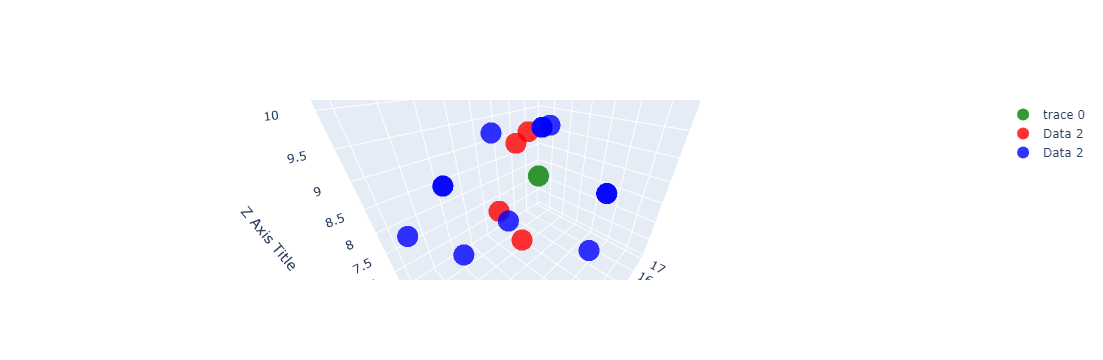

In [117]:
import numpy as np
import plotly.graph_objs as go
from IPython.display import display
from plotly.io import write_html

# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=[poi[0]],
    y=[poi[1]],
    z=[poi[2]],
    mode='markers',
    marker=dict(
        size=12,
        color="green",                # set color to the z coordinate
        opacity=0.8
    )
)])

# # Add trace for data2
fig.add_trace(go.Scatter3d(
    x=deg_1_neighbors[:,0],
    y=deg_1_neighbors[:,1],
    z=deg_1_neighbors[:,2],
    mode='markers',
    marker=dict(
        size=12,             
        color='red',  
        opacity=0.8
    ),
    name='Data 2'
))

fig.add_trace(go.Scatter3d(
    x=deg_2_neighbors_np[:,0],
    y=deg_2_neighbors_np[:,1],
    z=deg_2_neighbors_np[:,2],
    mode='markers',
    marker=dict(
        size=12,    
        color='blue',
        opacity=0.8
    ),
    name='Data 2'
))

# Update layout
fig.update_layout(scene=dict(
    xaxis_title='X Axis Title',
    yaxis_title='Y Axis Title',
    zaxis_title='Z Axis Title'
))

# Show plot
fig.show()
write_html(fig, file="scatter_plot.html")
# write_image(fig, file="scatter_plot.svg")
# display(fig)

In [22]:
##3 just for loop swill be enough to generate the connections tensor 
### keep defining the ctree every iteration to remove copies ###  